# Conservative Policy Iteration(CPI)

---

今回はConservative Policy Iteration(CPI)について解説していきます．

まず, CPIを説明する前にmonotonic improvement(MI) を説明します．

MIとは次のようなことが保証されているアルゴリズムです．

tを時間ステップ，$\pi^t$をtステップ時の方策，$V$を状態価値関数とします．

$$
V^{\pi^{t+1}} - V^{\pi^t} \geq 0
$$

上の式の意味は更新後の状態価値関数は更新前の状態価値関数よりも大きくなっているということです．

---

ここからCPIの説明をしていきます．

CPIのポリシーの更新は次のようになります．

$\pi^\prime$は現時点でのgreedyなポリシーとします．

$$
\pi_\alpha=(1-\alpha) \pi+\alpha \pi^{\prime}
$$

このようにして，今の方策と混ぜながら更新することによって

次に，説明するのに便利な記法を導入していきます．

まず，割引将来状態分布を次のように書きます．

ここで出てくる$\mu$は任意のsの初期分布です．(generative modelと同じ)

$$
d_{\pi, \mu}(s) \equiv(1-\gamma) \sum_{t=0}^{\infty} \gamma^t \operatorname{Pr}\left(s_t=s ; \pi, \mu\right)
$$

他にAdvantage functionとして$A^\pi(s,a) = Q^\pi(s,a) - V^\pi(s,a)$という関数も使うと上で示したMIの式はCPIだと次のようになります．

$$
V_\mu^{\pi^{t+1}}-V_\mu^{\pi^t}=\frac{1}{1-\gamma} \mathbb{E}_{s \sim d_\mu^{{\mu}^{t+1}}} A^{\pi^t}\left(s, \pi^{t+1}(s)\right)=\frac{\alpha}{1-\gamma} \mathbb{E}_{s \sim d {\mu}^{t+1}} A^{\pi^t}\left(s, \pi^{\prime}(s)\right),
$$

ここで報酬のバウンドを$[0,1]$で考えると，状態価値関数$V$のバウンドは$[0,1/(1-\gamma)]$となり，Advantage functionは0以上を取ることがわかり，右辺は0以上が保たれます．


---

コードを書いていきます．

CPIのアルゴリズムは以下のようになります．

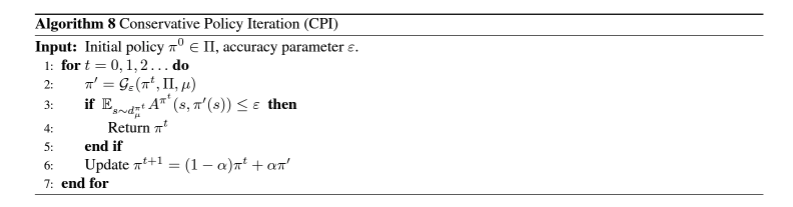

In [2]:
import numpy as np
from typing import NamedTuple

S = 5 #state_size
A = 3  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.99 

rew = np.random.rand(S,A) * 10 #報酬

P = np.random.rand(S*A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

mdp = MDP(S_array,A_array,gamma,rew,P)
print(mdp.rew.shape)
print(mdp.P.shape)

(5, 3)
(5, 3, 5)


In [36]:
import jax.numpy as jnp
import jax


@jax.jit
def Conservative_Policy_Iteration(mdp:MDP,q:jnp.ndarray,pi:jnp.ndarray,alpha:float):
    # Compute the max policy
    pi_max = jnp.zeros_like(pi)
    pi_max = pi_max.at[np.arange(S),q.argmax(axis=1)].set(1)
    # Compute the new policy
    new_pi = (1-alpha) * pi + alpha * pi_max
    # Compute the new value function
    v = (new_pi * q).sum(axis=-1)
    # Compute the new Q function
    q = mdp.rew + mdp.gamma * mdp.P @ v
    # Compute the advantage
    advantage = q - v[:,None]
    assert q.shape == (mdp.S,mdp.A)
    assert advantage.shape == (mdp.S,mdp.A)
    return q,advantage

def terminate(advantage:jnp.ndarray,q:jnp.ndarray,epsilon:float):
    # Compute the maximum pi for each state
    pi_max = jnp.zeros((S,A))
    pi_max = pi_max.at[np.arange(S),q.argmax(axis=1)].set(1)

    # Compute the sum of all advantage for each state
    sum_advantage = (pi_max*advantage).sum(axis=-1).sum(axis=-1)
    print(sum_advantage)
    return (sum_advantage < epsilon)


  2%|▎         | 25/1000 [00:00<00:09, 103.14it/s]

33.06109
33.01819
33.01436
33.01402
33.013992
33.01399
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


  8%|▊         | 76/1000 [00:00<00:04, 188.48it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 13%|█▎        | 131/1000 [00:00<00:03, 229.34it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 18%|█▊        | 182/1000 [00:00<00:03, 240.96it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 24%|██▍       | 238/1000 [00:01<00:02, 257.02it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 29%|██▉       | 294/1000 [00:01<00:02, 263.16it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 35%|███▍      | 348/1000 [00:01<00:02, 252.75it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 41%|████      | 406/1000 [00:01<00:02, 268.91it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 46%|████▋     | 464/1000 [00:01<00:01, 275.62it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 52%|█████▏    | 522/1000 [00:02<00:01, 276.69it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 58%|█████▊    | 580/1000 [00:02<00:01, 276.93it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 64%|██████▎   | 637/1000 [00:02<00:01, 278.16it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 66%|██████▋   | 665/1000 [00:02<00:01, 208.25it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 72%|███████▏  | 717/1000 [00:02<00:01, 230.13it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 77%|███████▋  | 772/1000 [00:03<00:00, 236.87it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 82%|████████▏ | 824/1000 [00:03<00:00, 240.55it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 88%|████████▊ | 881/1000 [00:03<00:00, 259.39it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 94%|█████████▎| 936/1000 [00:03<00:00, 255.41it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


 99%|█████████▉| 993/1000 [00:04<00:00, 267.16it/s]

33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985
33.013985


100%|██████████| 1000/1000 [00:04<00:00, 245.15it/s]

33.013985


Text(0.5, 0, 'iteration')

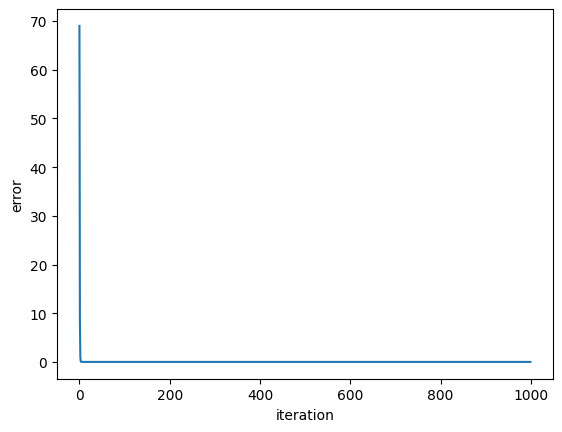

In [37]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

S,A = mdp.S, mdp.A
pi = jnp.zeros((S,A))
q_before = jax.random.uniform(key = key,shape = (S,A))
errors = []
from tqdm import tqdm
for i in tqdm(range(1000)):
    q_after,advantage = Conservative_Policy_Iteration(mdp,q_before,pi,0.1)
    error = jnp.abs(q_after - q_before).sum()
    q_before = q_after
    errors.append(error)
    if terminate(advantage,q_after,0.01):
        print('end')
        break

plt.plot(errors)
plt.ylabel('error')
plt.xlabel('iteration')